# Sketch colorization using Pix2Pix

Original paper: [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004)

Dataset used for training: https://www.kaggle.com/datasets/ktaebum/anime-sketch-colorization-pair

Colorization is the one of the basic GAN tasks. This specific domain however introduces a tricky challenge: color palette tends to be very non-uniform, defined by the certain character design, or (in the cases of OC) limited only by the artist's imagination.

To address the issue without diverging from the original paper much, we'll be extracting the colormap from the image and pass it to the generator bottleneck. Given no colormap, it will be sampled from a uniform random distribution.

Though the original dataset comes with JSON colormaps, we decided to make the approach more flexible and extract colormaps as we go. Current implementation extracts 8 prevalent colors, it also allows to supply a reference color image. Though this is an imperfect solution (it breaks fully convolutional translation, and undithered extraction quality is questionable), this is about as far as we can go without major changes to the architecture.

Additionally, the model will be trained and tested on a stock task from the original paper (all the stock datasets: https://www.kaggle.com/datasets/vikramtiwari/pix2pix-dataset), 

Required units:

- PyTorch
- Albumentations
- 🤗 accelerate
- Pillow
- colorgram.py
- NumPy
- Matplotlib
- tqdm

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW

from torchsummary import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

from accelerate import Accelerator

import colorgram
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
from tqdm.notebook import tqdm

from pathlib import Path
from IPython.display import clear_output
from multiprocessing import Pool

In [2]:
torch.backends.cudnn.benchmark = True
BATCH_SIZE = 16
COLORMAP_SIZE = 8
NUM_WORKERS = 12
accelerator = Accelerator()
DEVICE = accelerator.device
print("The model will be running on", DEVICE, "device")

The model will be running on cuda device


## Data review

In [3]:
TRAIN_DIR = 'storage/datasets/ASC/train/'
TEST_DIR = 'storage/datasets/ASC/val/'
STOCK_TRAIN_DIR = 'storage/datasets/maps/maps/train/'
STOCK_TEST_DIR = 'storage/datasets/maps/maps/val/'

(1024, 512)


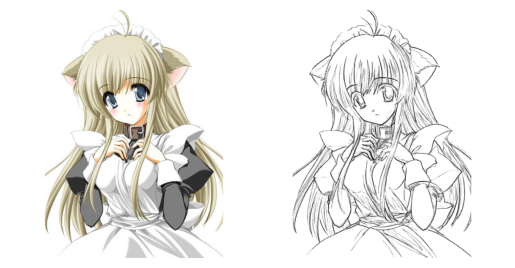

In [4]:
image = Image.open(Path(TRAIN_DIR, '10001.png'))
plt.imshow(image);
plt.axis('off');
print(image.size)

The dataset contains 512x512 image pairs concatenated together. That means:

- both source and target are RGB;
- sketches are very uniform in style, this may cause troubles with differently drawn sources;

## Data preprocessing

### Augmentations

When augmenting, we'll need to make sure **positional tranformations for the source and its target are exactly the same**. This can be achieved with Albumentations multitarget feature.

We augment the source (sketch) further (noise, blur, sharpening etc) so that the model is able to handle different line/background styles somewhat better. It is still recommended to supply a properly cropped source.

In [5]:
both_transform = A.Compose(
    [
        #A.Resize(width=256, height=256),
        A.RandomSizedCrop([128, 512], width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=3, p=0.2),
        A.OneOf([
                    A.OpticalDistortion(p=0.3),
                    A.GridDistortion(p=.1),
                    A.PiecewiseAffine(p=0.3),
                ], p=0.2),
    ],
    additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.GaussNoise(),
        A.OneOf([
                    A.MotionBlur(p=.2),
                    A.MedianBlur(blur_limit=3, p=0.1),
                    A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
                    A.CLAHE(clip_limit=2),
                    A.Sharpen(),
                    A.Emboss(),
                    A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

### Dataset implementation

In [6]:
# Extract from the downscaled image for the performance sake (target half only):
pre_extraction_left_half = lambda filename: Image.fromarray(A.Compose(
    [
        A.SmallestMaxSize (max_size=256, interpolation=2),
        A.Crop(x_max=256, y_max=256)
    ])
    (image=np.array(Image.open(filename).convert("RGB")))["image"])


In [7]:
class SplitDataset(Dataset):
    '''
    Sketch-colorized image pairs vertically stacked in a single file.
    '''
    @staticmethod
    def process_dir(path):
        '''
        Extracts the observation id and the colorgram.
        '''
        return (path.name, colorgram.extract(pre_extraction_left_half(path), COLORMAP_SIZE))
    
    def __init__(self, root, size=512):
        '''
        Accepts the dataset directory. Prepares a file list and colorgram list.
        Cologram extraction is a resource-heavy operation and utilizes multiprocessing.
        Estimated initialization time: 10 min (Ryzen 3600X, 12 threads, M2 SSD).
        Default individual image size is assumed to be 512x512.
        '''
        self.root = root
        self.size = size
        self.files = []
        # build a list of files:
        pool = Pool(12)
        path1 = Path(root)
        top = [dir for dir in filter(Path.is_file, path1.iterdir())]
        results = pool.map(SplitDataset.process_dir, top)
        if results:
            self.files.extend(results)
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        filename, cgram = self.files[idx]
        path = Path(self.root, filename)
        image = np.array(Image.open(path))
        
        # Split:
        target = image[:, :self.size, :]
        source = image[:, self.size:, :]
        
        # Augment:
        augmentations = both_transform(image=source, image0=target)
        source = augmentations["image"]
        target = augmentations["image0"]

        source = transform_only_input(image=source)["image"]
        target = transform_only_mask(image=target)["image"]
        
        # Pass the cologram further as a flattened array:
        rgb = np.array([c.rgb.r for c in cgram] + [c.rgb.g for c in cgram] + [c.rgb.b for c in cgram]).astype('float32') / 255.
        rgb = np.pad(rgb, (0, COLORMAP_SIZE * 3 - len(rgb)), constant_values=1)
        return source, target, torch.from_numpy(rgb)

## Building a model

We'll utilize PixelNorm (akin to ProGAN/StyleGAN), resulting in a more vivid color palette and less artifacts:

In [8]:
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.epsilon = torch.finfo(torch.float32).eps
    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

### Discriminator

Differences from the original paper: 

- PixelNorm (worth noting that later official implementations swicthed from `BatchNorm2d()` to `InstanceNorm2d(affine=True)`).
- Mish activation (very similar to SiLU, but we decided to try it for the experiment's sake).

In [9]:
class DiscBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, bias=False, padding_mode='reflect'),
            PixelNorm(),
            nn.Mish(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.model = nn.Sequential(
            # both source and target come in, thus double the amount of channels:
            nn.Conv2d(in_channels * 2, 64, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.Mish(inplace=True),
            DiscBlock(64, 128),
            DiscBlock(128, 256),
            DiscBlock(256, 512, stride=1),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'),
        )
        
    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        return self.model(x)

### Generator

To improve the pallette choice, we concatenate the cologram embedding with the bottleneck part of the generator.

Other differences from the original paper: 

- PixelNorm, like discriminator.
- Mish activation is present where the orinal paper used `LeakyReLU()`.
- Dropout is currently disabled inside the block `forward()` routine, but can be easily brought back.

In [11]:
class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act='relu', use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, padding_mode='reflect') if down else
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            PixelNorm(),
            nn.ReLU(inplace=True) if act=='relu' else nn.Mish(inplace=True),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.conv(x)
        return x #self.dropout(x) if self.use_dropout else x

In [12]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, n_features=64):
        super().__init__()
        
        # No normalizing here.
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, n_features, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.Mish(inplace=True)
        )
        self.down1 = GenBlock(n_features, n_features*2, act='mish')
        self.down2 = GenBlock(n_features*2, n_features*4, act='mish')
        self.down3 = GenBlock(n_features*4, n_features*8, act='mish')
        self.down4 = GenBlock(n_features*8, n_features*8, act='mish')
        self.down5 = GenBlock(n_features*8, n_features*8, act='mish')
        self.down6 = GenBlock(n_features*8, n_features*8, act='mish')
        
        self.embedding = nn.Linear(COLORMAP_SIZE * 3, 64)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(n_features*8, n_features*8, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.ReLU(inplace=True),
            #nn.Mish(inplace=True),
        )
        
        self.up1 = GenBlock(n_features*9, n_features*8, down=False, use_dropout=True)
        self.up2 = GenBlock(n_features*16, n_features*8, down=False, use_dropout=True)
        self.up3 = GenBlock(n_features*16, n_features*8, down=False, use_dropout=True)
        self.up4 = GenBlock(n_features*16, n_features*8, down=False)
        self.up5 = GenBlock(n_features*16, n_features*4, down=False)
        self.up6 = GenBlock(n_features*8, n_features*2, down=False)
        self.up7 = GenBlock(n_features*4, n_features, down=False)
    
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(n_features*2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x, colorgram=None):
        if colorgram == None:
            rgb = torch.rand(COLORMAP_SIZE * 3).to(DEVICE).repeat(x.shape[0],1)
        else:
            rgb = colorgram
        
        # Normalize colors:
        rgb = rgb - 0.5
        
        initial = self.initial_down(x)
        conv1 = self.down1(initial)
        conv2 = self.down2(conv1)
        conv3 = self.down3(conv2)
        conv4 = self.down4(conv3)
        conv5 = self.down5(conv4)
        conv6 = self.down6(conv5)
        
        mid = self.bottleneck(conv6)
        embed = self.embedding(rgb)
        latent = torch.cat([mid, embed.unflatten(1, torch.Size(([64, 1, 1])))], dim=1)
        
        upconv1 = self.up1(latent)
        upconv2 = self.up2(torch.cat([upconv1, conv6], dim=1))
        upconv3 = self.up3(torch.cat([upconv2, conv5], dim=1))
        upconv4 = self.up4(torch.cat([upconv3, conv4], dim=1))
        upconv5 = self.up5(torch.cat([upconv4, conv3], dim=1))
        upconv6 = self.up6(torch.cat([upconv5, conv2], dim=1))
        upconv7 = self.up7(torch.cat([upconv6, conv1], dim=1))
        result = self.final_up(torch.cat([upconv7, initial], dim=1))
        return result

In [13]:
summary(Generator().to(DEVICE), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
              Mish-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
         PixelNorm-4          [-1, 128, 64, 64]               0
              Mish-5          [-1, 128, 64, 64]               0
          GenBlock-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,288
         PixelNorm-8          [-1, 256, 32, 32]               0
              Mish-9          [-1, 256, 32, 32]               0
         GenBlock-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 16, 16]       2,097,152
        PixelNorm-12          [-1, 512, 16, 16]               0
             Mish-13          [-1, 512, 16, 16]               0
         GenBlock-14          [-1, 512,

In [14]:
discriminator = Discriminator()
generator = Generator()

In [15]:
class MyGAN:
    def __init__(self, discriminator, generator, lr=5e-4, ratio=5.):
        disc_optim = AdamW(discriminator.parameters(), lr=lr/ratio, betas=(0.5, 0.999))
        gen_optim = AdamW(generator.parameters(), lr=lr, betas=(0.5, 0.999))
        
        self.discriminator, self.generator, self.disc_optim, self.gen_optim = accelerator.prepare(
                                                                                                    discriminator,
                                                                                                    generator,
                                                                                                    disc_optim,
                                                                                                    gen_optim,
                                                                                                 )
        self.criterion = nn.BCEWithLogitsLoss()
        self.similarity = nn.L1Loss()
        
    def train(self, epochs, data_tr, data_val):
        # Forward declaration:
        return train_gan(self, epochs, data_tr, data_val)

In [16]:
# Optional: DCGAN-style weight initialization, seems to improve the stability a bit.
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [17]:
initialize_weights(discriminator)
initialize_weights(generator)

In [18]:
model = MyGAN(discriminator, generator)

## Training

In [19]:
class History:
    '''
    A struct for training/validation stats.
    '''
    def __init__(self, name='Unknown'):
        self.disc_loss = []
        self.gen_loss = []
        self.gen_loss_valid = []
        self.name = name
        
    def add(self, gen_loss, disc_loss=None, valid=False):
        '''
        Add record.
        '''
        if not valid:
            self.disc_loss.append(disc_loss)
            self.gen_loss.append(gen_loss)
        else:
            self.gen_loss_valid.append(gen_loss)
    def best_epoch(self):
        '''
        Best validation epoch for the generator.
        '''
        return np.argmin(np.array(self.gen_loss_valid))
    def display(self):
        '''
        Display stats.
        '''
        fig, ax = plt.subplots(1, 1, figsize=(16, 5))
        ax.set(xlim=(0, len(self.disc_loss)-1), ylim=(0, max(self.gen_loss_valid)), xlabel='Epoch')
        plt.plot(self.disc_loss);
        plt.plot(self.gen_loss);
        plt.plot(self.gen_loss_valid);
        plt.legend(['discriminator loss', 'generator loss (training)', 'generator loss(validation)']);
        print(f'{self.name}: best loss {min(self.gen_loss_valid):.4f} at epoch {self.best_epoch()+1}')

In [20]:
# Save/load routines: 
def save_checkpoint(model, optimizer, filename):
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer):
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [21]:
picture = lambda t: (t * 0.5 + 0.5).permute(1, 2, 0).cpu().detach().numpy()

In [22]:
def train_gan(model, epochs, data_tr, data_val):
    title = f'{type(model).__name__}'
    history = History(title)
    disc_sched = torch.optim.lr_scheduler.CosineAnnealingLR(model.disc_optim, T_max=epochs, eta_min=1e-7)
    gen_sched = torch.optim.lr_scheduler.CosineAnnealingLR(model.gen_optim, T_max=epochs, eta_min=1e-7)

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        loss_disc = 0
        loss_gen = 0

        for source, target, cgram in tqdm(data_tr):
            model.discriminator.train()
            model.generator.train()
            
            # Colorize:
            fake = model.generator(source, cgram)
            # Check the discriminator against real and generated images:
            estimation_real = model.discriminator(source, target)
            estimation_fake = model.discriminator(source, fake.detach())
            real_loss = model.criterion(estimation_real, torch.ones_like(estimation_real))
            fake_loss = model.criterion(estimation_fake, torch.zeros_like(estimation_fake))
            # Average loss:    
            disc_loss = (real_loss + fake_loss) / 2.
            model.disc_optim.zero_grad()
            accelerator.backward(disc_loss)
            model.disc_optim.step()
            loss_disc += disc_loss
            
            # Check the generator result against the discriminator:
            estimation_fake = model.discriminator(source, fake)
            fake_loss = model.criterion(estimation_fake, torch.ones_like(estimation_fake))
            # Check the generator result against the ground truth:
            target_loss = model.similarity(fake, target) * 100.
            # Weighted sum:
            gen_loss = fake_loss + target_loss
        
            model.gen_optim.zero_grad()
            accelerator.backward(gen_loss)
            model.gen_optim.step()
            loss_gen += gen_loss
        
        disc_sched.step()
        gen_sched.step()
        
        loss_disc /= len(data_tr)
        loss_gen /= len(data_tr)    
        history.add(loss_gen.detach().cpu(), loss_disc.detach().cpu())
        print(f'Epoch {epoch}: disc loss {loss_disc:.2f}, gen loss {loss_gen:.2f}')            

        model.discriminator.eval()
        model.generator.eval()
        
        loss_gen = 0
        
        # Validation:
        with torch.no_grad():
            for source, target, cgram in tqdm(data_val):
                fake = model.generator(source, cgram)
                estimation_fake = model.discriminator(source, fake)
                fake_loss = model.criterion(estimation_fake, torch.ones_like(estimation_fake))
                target_loss = model.similarity(fake, target) * 100.
        
                gen_loss = fake_loss + target_loss
                loss_gen += gen_loss
            
            loss_gen /= len(data_val)
            history.add(loss_gen.detach().cpu(), valid=True)

        clear_output(wait=True)
        fig, axes = plt.subplots(1, 8, figsize=(16,4));
        for k, ax in enumerate(axes.flatten()):
            ax.imshow(picture(source[k]));
            ax.axis('off');
        plt.show();
        fig, axes = plt.subplots(1, 8, figsize=(16,4));
        for k, ax in enumerate(axes.flatten()):
            ax.imshow(picture(target[k]));
            ax.axis('off');
        plt.show();
        fig, axes = plt.subplots(1, 8, figsize=(16,4));
        for k, ax in enumerate(axes.flatten()):
            ax.imshow(picture(fake[k]));
            ax.axis('off');
        plt.show();
        fig, axes = plt.subplots(1, 8, figsize=(16,2));
        for k, ax in enumerate(axes.flatten()):
            colors = np.split(cgram[k].cpu().numpy(), COLORMAP_SIZE)
            for i, color in enumerate(colors):
                ax.barh([''], 1, align='center', left=i, color=color);
                ax.axis('off');
        plt.suptitle(f'Epoch {epoch+1}/{epochs}: disc loss {loss_disc:.2f}, gen loss {loss_gen:.2f}');
        plt.show();
        
        if epoch == history.best_epoch():
            save_checkpoint(model.discriminator, model.disc_optim, f'{title}-disc-ann.pth')
            save_checkpoint(model.generator, model.gen_optim, f'{title}-gen-ann.pth')
    torch.cuda.empty_cache()
    model.discriminator.eval()
    model.generator.eval()
    return history

### Stock task: map to aerial

Described in the original paper, this task translates the aerial overviews to maps, or vice versa (the latter is preferable for our end goal). This dataset is also relatively light, allowing for a quick quality assurance.

The task is expected be easier than the end goal: target style is quite uniform. Artifacts and small detail will likely become the main concern.

(1200, 600)


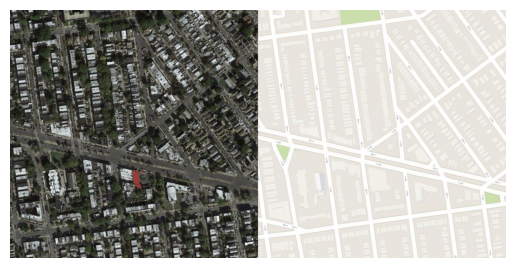

In [23]:
image = Image.open(Path(STOCK_TRAIN_DIR, '1.jpg'))
plt.imshow(image);
plt.axis('off');
print(image.size)

In [24]:
train_set = SplitDataset(STOCK_TRAIN_DIR, size=600)
test_set = SplitDataset(STOCK_TEST_DIR, size=600)

In [25]:
train_loader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=12)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=12, drop_last=True)

In [26]:
train_loader, test_loader = accelerator.prepare(train_loader, test_loader)

In [27]:
stock_discriminator = Discriminator()
stock_generator = Generator()

In [28]:
stock_model = MyGAN(stock_discriminator, stock_generator)

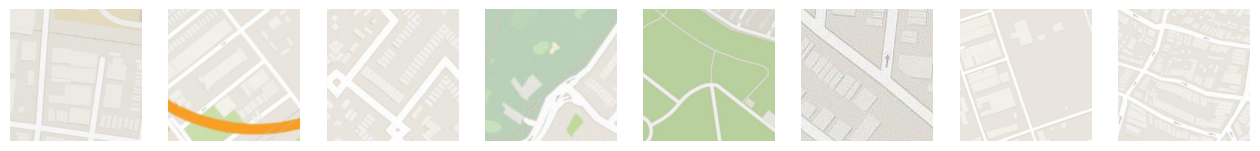

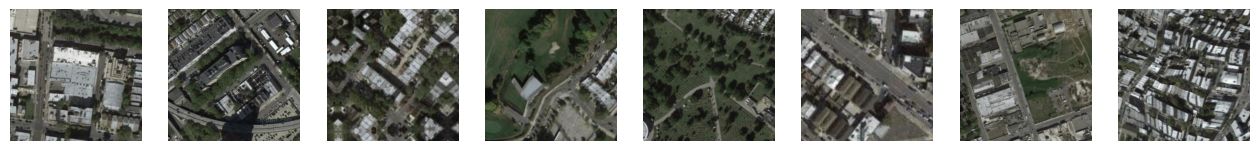

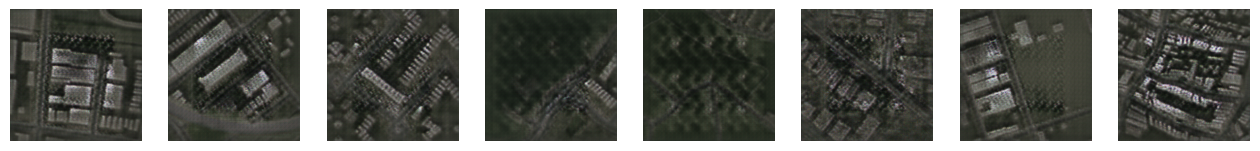

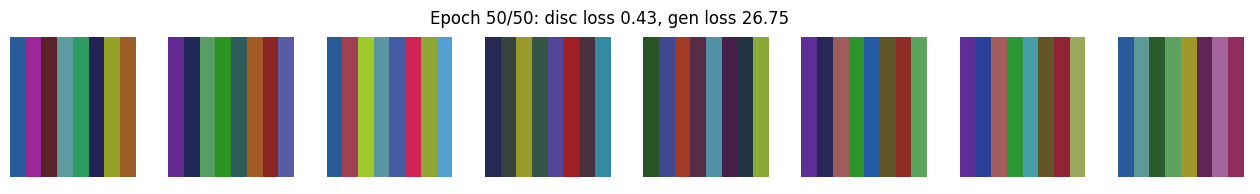

In [29]:
history = stock_model.train(50, train_loader, test_loader)

MyGAN: best loss 26.2606 at epoch 27


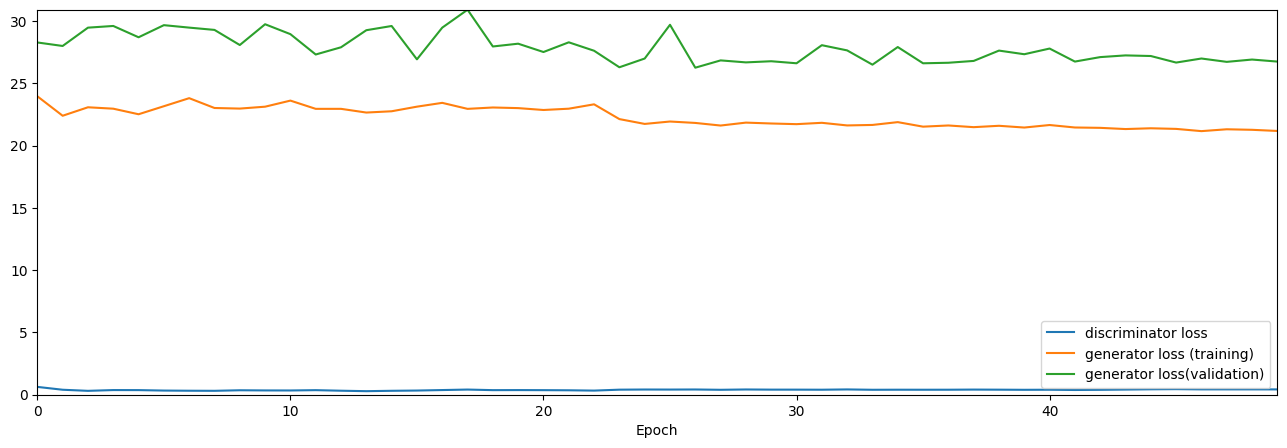

In [30]:
history.display()

Given the architerture tweaks for a patricular task and modest image/latent sizes, somewhat lesser quality compared to the paper (see below, probably cherry-picked as the paper states less than 20% of the generated images were considered good enough by human validators) is expectable. There's also some overfitting and artifacts appearing towards the end. Regardless, the reconstruction evidently matches the information present in the input.

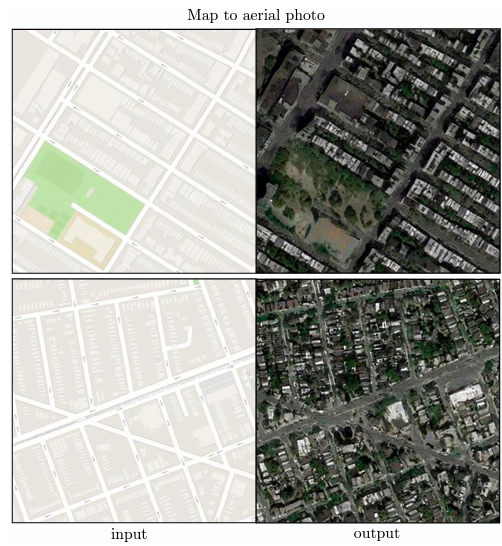

### Our task: sketch colorization

In [31]:
train_set = SplitDataset(TRAIN_DIR)
test_set = SplitDataset(TEST_DIR)

In [32]:
train_loader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=12)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=12, drop_last=True)

In [33]:
train_loader, test_loader = accelerator.prepare(train_loader, test_loader)

In [34]:
#load_checkpoint('MyGAN-disc-ann.pth', model.discriminator, model.disc_optim)
#load_checkpoint('MyGAN-gen-ann.pth', model.generator, model.gen_optim)

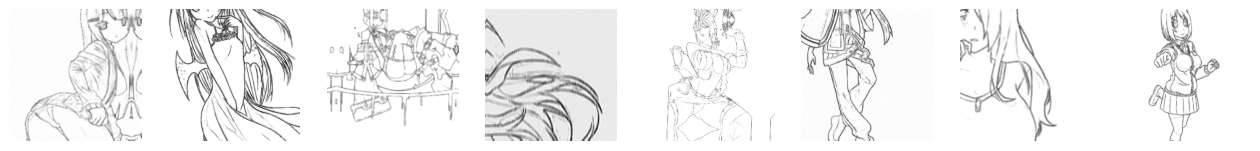

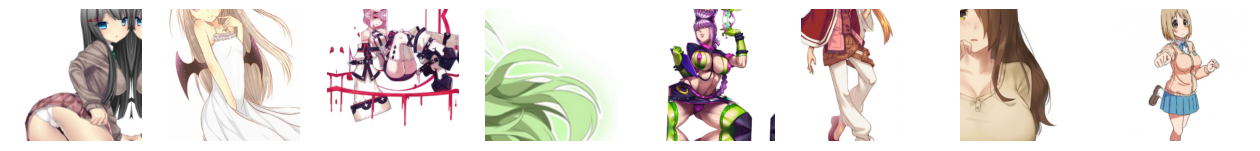

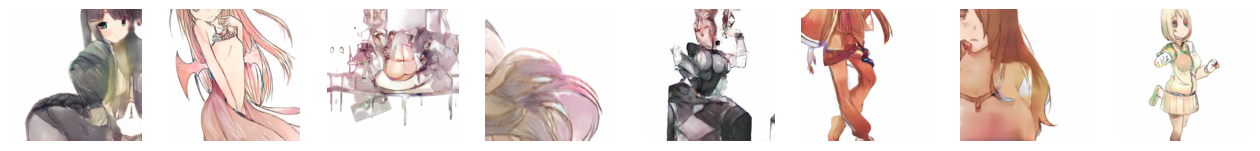

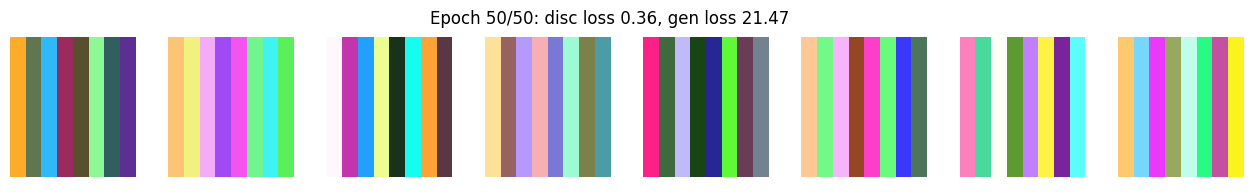

In [35]:
history = model.train(50, train_loader, test_loader)

MyGAN: best loss 21.3404 at epoch 40


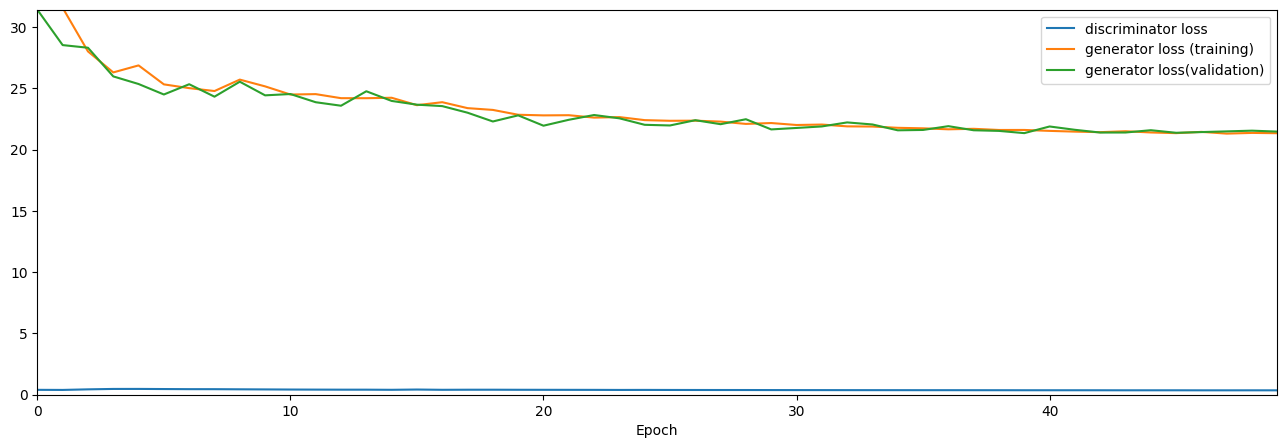

In [36]:
history.display()

## Inference

In [37]:
inference_transform = A.Compose(
    [
        A.ToGray(),
        A.Resize(256,256),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

In [38]:
pre_extraction = lambda filename: Image.fromarray(A.Compose(
    [
        A.Resize(width=256, height=256, interpolation=2)
    ])
    (image=np.array(Image.open(filename).convert("RGB")))["image"])

In [39]:
def colorize(source, cgram=None):
    rgb = None
    with Image.open(source) as image:
        width, height = image.size
        if cgram:
            cgram = colorgram.extract(pre_extraction(cgram), COLORMAP_SIZE)
            rgb = np.array([c.rgb.r for c in cgram] + [c.rgb.g for c in cgram] + [c.rgb.b for c in cgram]).astype('float32') / 255.
        image = np.array(image.convert("RGB"))
        input_tensor = inference_transform(image=image)["image"]
        input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
        with torch.no_grad():
            # Numpy arrays have no single truth value:
            if not np.all(np.equal(rgb, None)):
                result = model.generator(input_batch.to(DEVICE), torch.from_numpy(rgb).unsqueeze(0).to(DEVICE))
            else:
                result = model.generator(input_batch.to(DEVICE))
            result = A.Compose([A.Resize(width=width, height=height, interpolation=3)])(image=picture(result[0]))["image"]
        return result

In [40]:
def demonstration(source, cgram=None):
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for i in range(4):
        result = colorize(source, cgram)
        axes.flatten()[i].imshow(Image.open(source).convert("RGB"));
        axes.flatten()[i].axis('off');
        axes.flatten()[i+4].imshow(result);
        axes.flatten()[i+4].axis('off');

In [41]:
load_checkpoint('MyGAN-gen-ann.pth', model.generator, model.gen_optim)

### Random colors

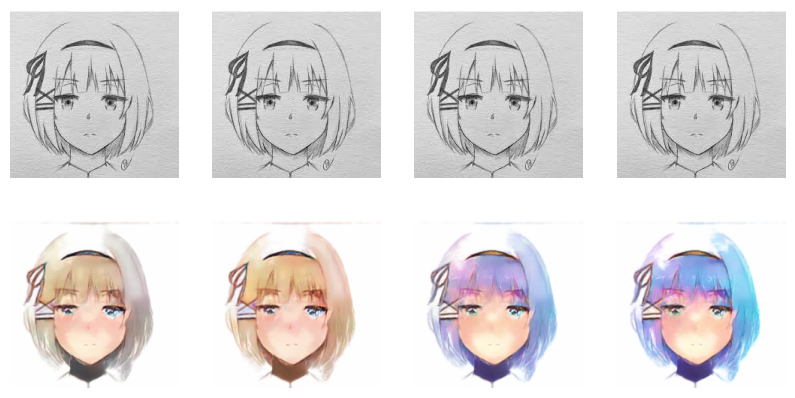

In [42]:
demonstration('1.jpg')

An arbitrary simple sketch, more or less compliant with the train set (notable differences: face only, toned background). Network correctly dilutes the darker background thanks to augmentations, apart from the darkest edge. Some color leakage noticeable. Note the attempts at lighting for the hair.

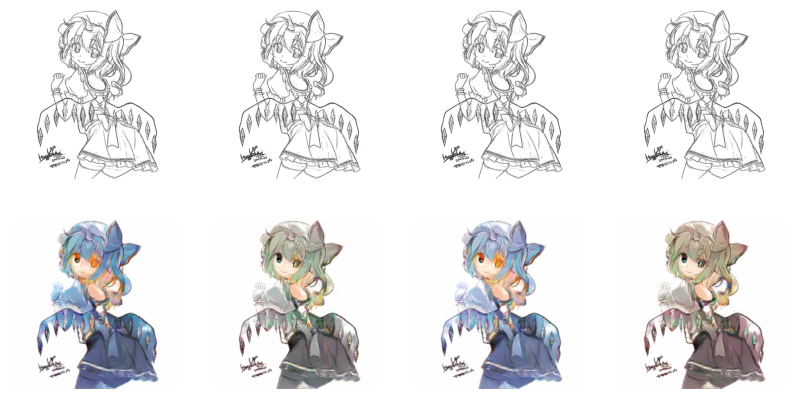

In [43]:
demonstration('2962113.png')

An example from the validation set, sans the colormap. Some color leakage still happens.

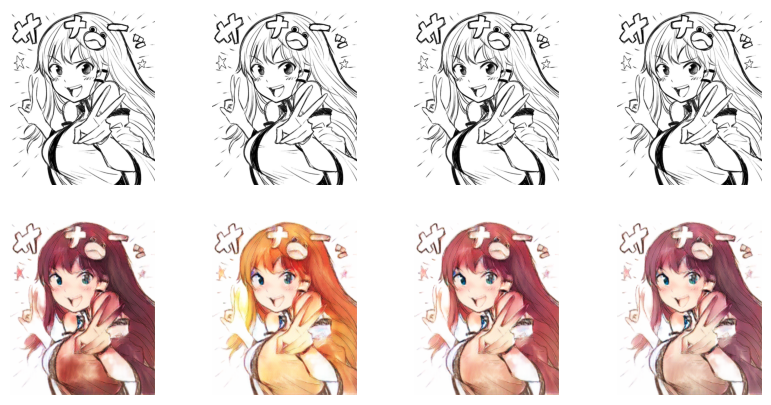

In [44]:
demonstration('Fm60wRWaMAQOcJo.jpg')

A complex sketch with variable line thickness, not compliant with the train set. The generation quality is worse, the network has trouble distinguishing between details.

### Colors supplied

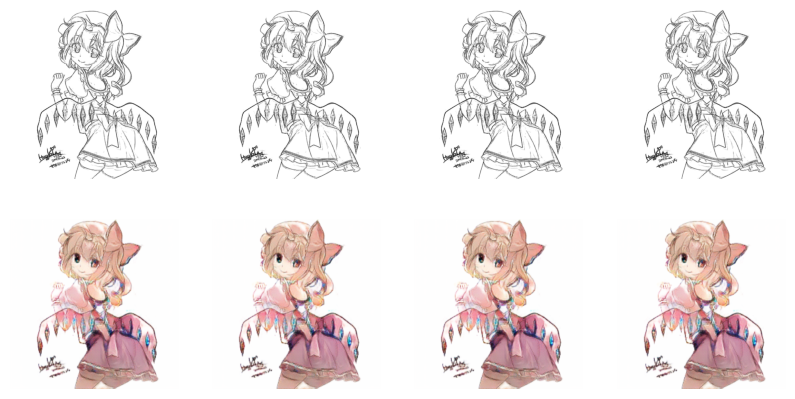

In [45]:
demonstration('2962113.png', 'FiATgcxUUAAUewl.jpg')

Supplied with the same character reference in a white shirt and pronounced blush. Pink color becomes dominating, wings are properly multicolored. Note that results with a reference are deterministic.

Reference: 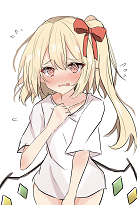

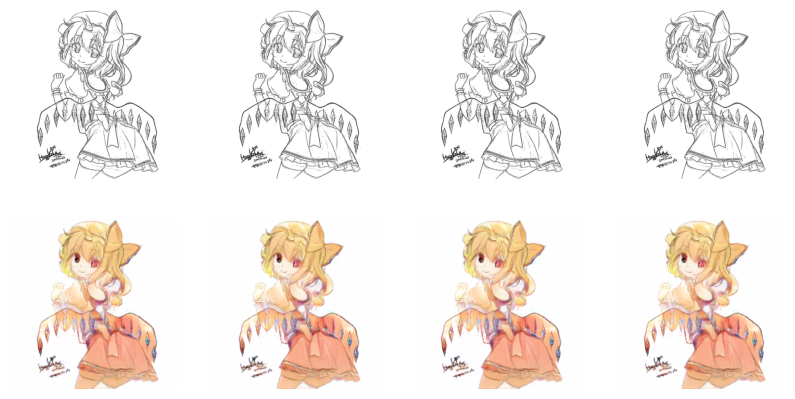

In [46]:
demonstration('2962113.png', 'FiaN56eUAAAaVUM.jpg')

Supplied with the same character reference in a white shirt and red skirt, with dark gray background; hair color is more pronounced yellow compared to an average. An interesting gradient mix of red and yellow is produced, wings are properly multicolored.

Reference: 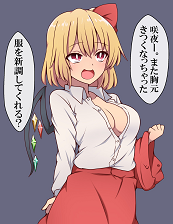

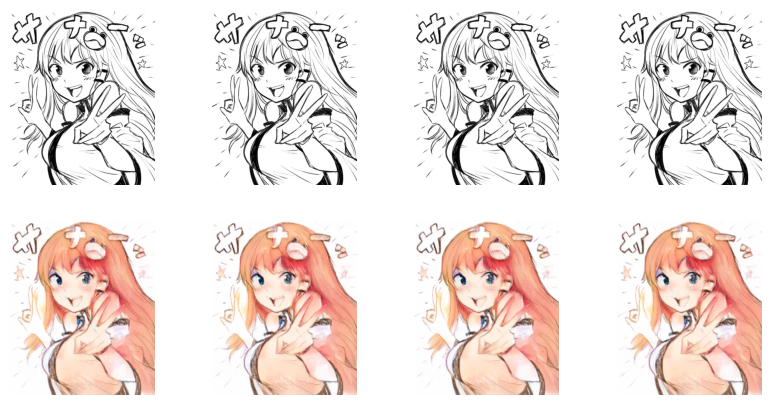

In [47]:
demonstration('Fm60wRWaMAQOcJo.jpg', 'FiaN56eUAAAaVUM.jpg')

Supplied with the same (non-canonical) reference. The pallette is similar - note the hand coloration error happens both with and without a colormap.

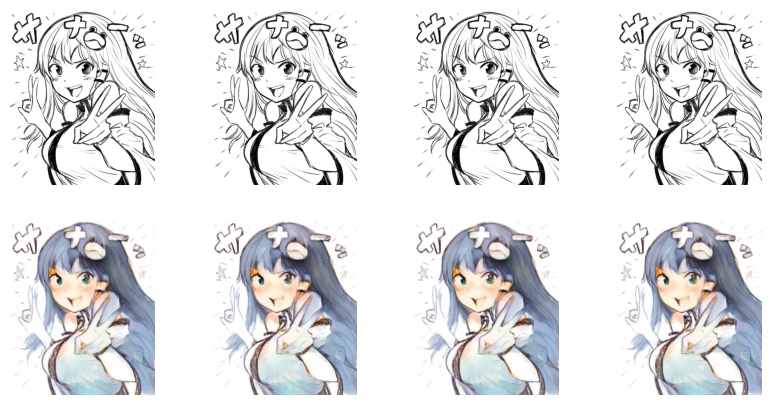

In [48]:
demonstration('Fm60wRWaMAQOcJo.jpg', 'Faqr8ZDaUAAAG3B.jpg')

Supplied with a canonical character reference. As with a random example, the major colors are distributed as a soft gradient rather than distinct green, blue and while. This calls for a better adaptation of the network to different sketch styles.

Reference: 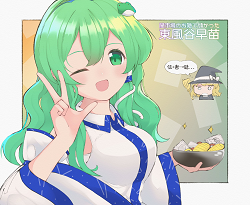

## Further improvement

Sadly, the time constraints did not allow to polish the inference part yet. The most obvious next step will be resizing the result using a separate superresolution network (this is known to yield better results compared to fully convolutional approach anyway).

Finding more fitting augmentations and/or extending the train set should improve the processing of various sketch styles. Achieving a more brush-like variable line width looks like the priority. Grayscale and floodfilled images aren't working well yet. Random cropping improves the quality of non-fullbody sketches greatly but results in a more 'pastel' and less distinct coloration.

Due to hardware limitations, a 256x256 image size was chosen, however expanding to 512x512 is still within reasonable capabilities. More feature maps also increase the overall quality but require more computation time than the project allowed so far.

An interface for a selectable palette would be a better option than color extraction from a reference, as extraction is expensive and the result if often counterintuitive from a human PoV.